# LightGBM Test Run

### summary

- 'gender' and 'device' are discrete strings -> dummies (keep both M and F to capture nan info)
- 'drivers', 'vehicles', 'age', 'launch', and 'tenure' are all discrete numeric -> lgbm can handle
- target variable 'outcome' is imbalanced at approximately 1:9 -> use lgbm imbalanced setting
- multicolinearity with 'age', 'income', and 'tenure' -> lgbm (trees) is robust to colinearity

---

# EDA

In [1]:
# mac install for lightgbm

# !brew install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('train.csv')
print(data.shape)
list(data.columns)

(10000, 10)


['age',
 'cost_of_ad',
 'device_type',
 'gender',
 'in_initial_launch_location',
 'income',
 'n_drivers',
 'n_vehicles',
 'prior_ins_tenure',
 'outcome']

In [4]:
data.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [5]:
def summary(df):
    '''exploratory data analysis of a dataframe'''
    
    import pandas as pd
    
    summary = {}
    summary['count'] = df.count()
    summary['dtypes'] = df.dtypes
    summary['null_sum'] = df.isnull().sum()
    summary['null_pct'] = df.isnull().mean()
    summary['mean'] = df.mean()
    summary['median'] = df.median()
    summary['min'] = df.min()
    summary['max'] = df.max()
    
    return pd.DataFrame(summary)

In [6]:
summary(data)

,count,dtypes,null_sum,null_pct,mean,median,min,max
age,10000,int64,0,0.0000,37.991800,38.000000,16,60
cost_of_ad,10000,float64,0,0.0000,0.004666,0.004625,0.00317057,0.00708156
device_type,10000,object,0,0.0000,NaN,NaN,Android,other
gender,9731,object,269,0.0269,NaN,NaN,NaN,NaN
in_initial_launch_location,10000,int64,0,0.0000,0.497500,0.000000,0,1
income,10000,int64,0,0.0000,58004.335800,58053.500000,16241,99956
n_drivers,10000,int64,0,0.0000,1.497000,1.000000,1,2
n_vehicles,10000,int64,0,0.0000,2.002200,2.000000,1,3
outcome,10000,int64,0,0.0000,0.098200,0.000000,0,1
prior_ins_tenure,10000,int64,0,0.0000,5.406800,4.000000,0,22


In [7]:
def numeric_hists(df):
    '''quick histograms for numeric features'''
    
    import pandas as pd  
    import matplotlib.pyplot as plt
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            print(f'{col}:')
            plt.hist(df[col])
            plt.show()

age:


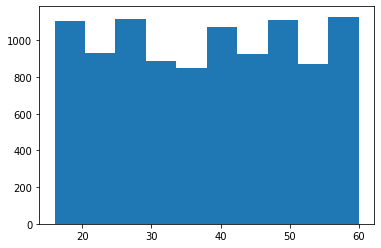

cost_of_ad:


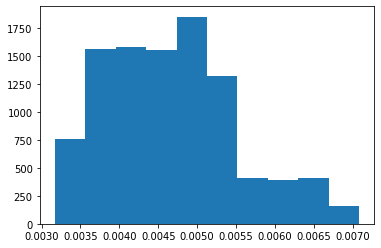

in_initial_launch_location:


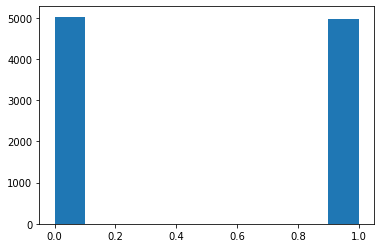

income:


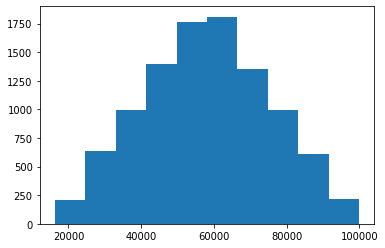

n_drivers:


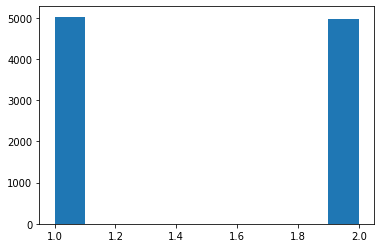

n_vehicles:


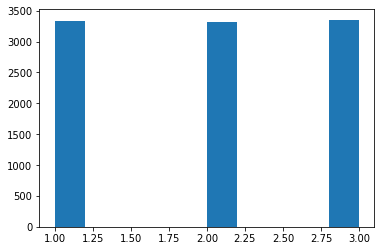

prior_ins_tenure:


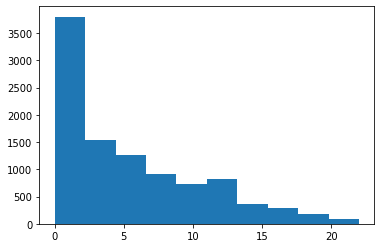

outcome:


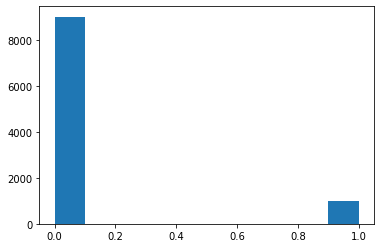

In [8]:
numeric_hists(data)

In [9]:
data.corr()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
age,1.000000,0.141522,-0.005112,0.747286,-0.005097,0.011210,0.644734,-0.011907
cost_of_ad,0.141522,1.000000,-0.000183,0.104408,-0.004596,-0.004071,0.086847,-0.077210
in_initial_launch_location,-0.005112,-0.000183,1.000000,0.003423,-0.001030,0.010530,0.008093,0.116577
income,0.747286,0.104408,0.003423,1.000000,-0.005122,0.005697,0.486532,0.006375
n_drivers,-0.005097,-0.004596,-0.001030,-0.005122,1.000000,0.006619,-0.003123,0.100105
n_vehicles,0.011210,-0.004071,0.010530,0.005697,0.006619,1.000000,0.004266,-0.193192
prior_ins_tenure,0.644734,0.086847,0.008093,0.486532,-0.003123,0.004266,1.000000,-0.029934
outcome,-0.011907,-0.077210,0.116577,0.006375,0.100105,-0.193192,-0.029934,1.000000


In [10]:
for idx, i in enumerate(data.columns):
    if data[i].dtype in ['int64', 'float64']:
        for j in data.columns[idx+1:]:
            if data[j].dtype in ['int64', 'float64']:
                r = data[[i, j]].corr().values[0][1]
                if abs(r) > 0.2:
                    print((i, j, r))

('age', 'income', 0.7472864357955471)
('age', 'prior_ins_tenure', 0.6447341586065465)
('income', 'prior_ins_tenure', 0.48653245183601684)


In [11]:
# missing gender has ~1/3 frequency of positive outcomes as overall data

round(data[data['gender'].isna()]['outcome'].mean(), 2), round(data['outcome'].mean(), 2)

(0.03, 0.1)

---

# Transformations

In [12]:
# z_scores

def z_score(col):
    mu = col.mean()
    sig = col.std()
    return [(i-mu)/sig for i in col]

for col in ['cost_of_ad', 'income']:
    data[col] = z_score(data[col])

In [13]:
# dummies

device = pd.get_dummies(data['device_type'], drop_first=True)
device.columns = [f'device_{i}' for i in device.columns]

gender = pd.get_dummies(data['gender'], drop_first=False)

data = data.drop(labels=['gender', 'device_type'], axis=1)
data = pd.concat([data, device, gender], axis=1)
data.head()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,device_desktop,device_iPhone,device_laptop,device_other,F,M
0,56,1.277293,0,0.271925,2,1,4,0,0,1,0,0,0,1
1,50,0.079356,0,0.364881,2,3,2,0,1,0,0,0,1,0
2,54,-0.640566,0,1.467601,1,3,7,0,0,0,1,0,0,1
3,16,0.538172,0,-1.609526,2,3,0,0,0,0,0,0,1,0
4,37,-1.230856,0,1.070965,2,1,5,0,1,0,0,0,0,1


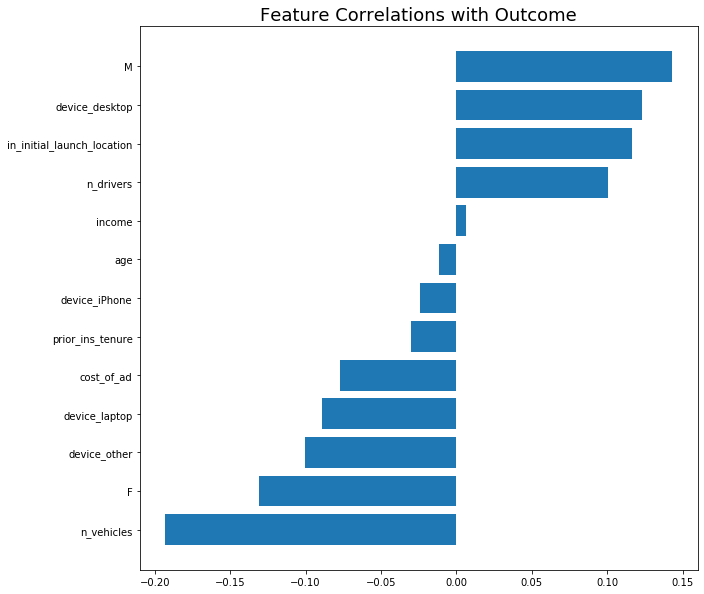

In [14]:
# feature correlations with outcome

correlations = []

for col in data.columns:
    if col == 'outcome':
        pass
    else:
        if data[col].dtype in ['int64', 'float64', 'uint8']:
            correlations.append((col, np.corrcoef(data[col], data['outcome'])[0][1])) # extract r
        else:
            dummies = pd.get_dummies(data[col])
            for col in dummies.columns:
                correlations.append((col, np.corrcoef(dummies[col], data['outcome'])[0][1]))
    
correlations = sorted(correlations, key = lambda x: x[1])

plt.figure(figsize=(10, 10))
plt.barh([i[0] for i in correlations],
         [i[1] for i in correlations])
plt.title('Feature Correlations with Outcome', fontsize=18);

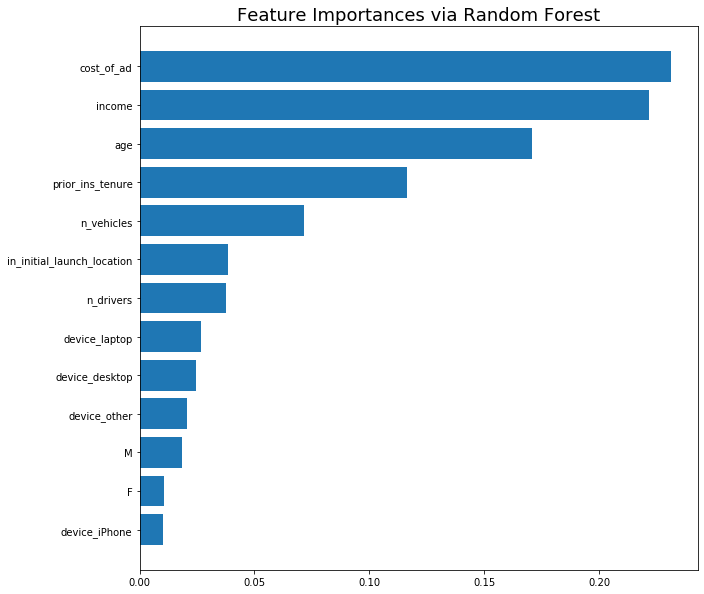

In [15]:
rfc = RandomForestClassifier(random_state=42)

X_train = data.drop(labels=['outcome'], axis=1)
y_train = data['outcome']

rfc = rfc.fit(X_train, y_train)

feats = sorted(zip(rfc.feature_importances_, X_train.columns), key=lambda x: x[0])

plt.figure(figsize=(10, 10))
plt.barh([i[1] for i in feats],
         [i[0] for i in feats])
plt.title('Feature Importances via Random Forest', fontsize=18);

---

# Modeling

In [16]:
def run_kfold(X_train, y_train, model, kfold):
    idx = 1
    in_ = []
    out_ = []
    for train_index, test_index in kfold.split(X_train, y_train):
        try:
            model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        except:
            y_train = pd.Series(y_train)
            model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        train_fp = model.predict(X_train.iloc[train_index])
        test_fp = model.predict(X_train.iloc[test_index])
        in_.append(metrics.roc_auc_score(y_train.iloc[train_index], train_fp))
        out_.append(metrics.roc_auc_score(y_train.iloc[test_index], test_fp))
        idx += 1
    return np.mean(in_), np.mean(out_)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [17]:
# default lgbm

lgb = lightgbm.LGBMClassifier(random_state=42,
                              is_unbalance=True)

in_, out_ = run_kfold(X_train, y_train, model=lgb, kfold=skf)
print(f'Average in auc:  {in_}')
print(f'Average oos auc:  {out_}')

Average in auc:  0.9268453521764481
Average oos auc:  0.7424621492044641


In [18]:
# some manual tuning for faster, smaller trees

lgb1 = lightgbm.LGBMClassifier(random_state=42,
                              is_unbalance=True,
                              learning_rate = 0.5,
                              num_leaves = 2**3-1,
                              num_trees = 50,
                              min_data_in_leaf = 200,
                              max_bin=2**3-1)

in_, out_ = run_kfold(X_train, y_train, model=lgb1, kfold=skf)
print(f'Average in auc:  {in_}')
print(f'Average oos auc:  {out_}')

Average in auc:  0.8098501444330222
Average oos auc:  0.7636953916961224


In [19]:
# model for slower, smaller trees

lgb2 = lightgbm.LGBMClassifier(random_state=42,
                              is_unbalance=True,
                              learning_rate = 0.1,
                              num_leaves = 2**3-1,
                              num_trees = 50,
                              min_data_in_leaf = 10,
                              max_bin=2**3-1)

in_, out_ = run_kfold(X_train, y_train, model=lgb2, kfold=skf)
print(f'Average in auc:  {in_}')
print(f'Average oos auc:  {out_}')

Average in auc:  0.780120472401631
Average oos auc:  0.7643729753402707


In [20]:
# model for slower, bigger trees

lgb3 = lightgbm.LGBMClassifier(random_state=42,
                              is_unbalance=True,
                              learning_rate = 0.005,
                              num_leaves = 2**5-1,
                              num_trees = 500,
                              min_data_in_leaf = 100,
                              max_bin=2**5-1)

in_, out_ = run_kfold(X_train, y_train, model=lgb3, kfold=skf)
print(f'Average in auc:  {in_}')
print(f'Average oos auc:  {out_}')

Average in auc:  0.8169493667952074
Average oos auc:  0.7635953421935509


In [21]:
# ensembling

in_all = []
out_all = []

for train_index, test_index in skf.split(X_train, y_train):
    
    in_ = []
    out_ = []
    for model in [lgb1, lgb2, lgb3]:
        model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        in_.append(model.predict_proba(X_train.iloc[train_index])[:,1])
        out_.append(model.predict_proba(X_train.iloc[test_index])[:,1])
    
    in_pred = [1 if (i * in_[1][idx] * in_[2][idx])**(1/3) > 0.5
               else 0 for idx, i in enumerate(in_[0])]
    out_pred = [1 if (i * out_[1][idx] * out_[2][idx])**(1/3) > 0.5
                else 0 for idx, i in enumerate(out_[0])]

    in_all.append(metrics.roc_auc_score(y_train.iloc[train_index], in_pred))
    out_all.append(metrics.roc_auc_score(y_train.iloc[test_index], out_pred))
    
print(f'Average in auc:  {np.mean(in_all)}')
print(f'Average oos auc:  {np.mean(out_all)}')

Average in auc:  0.806352829704306
Average oos auc:  0.7721049801337093
